In [99]:
#!pip install altair_saver -t /Users/mio/venv310/lib/python3.10/site-packages
#!pip install jpholiday

  Using cached jpholiday-0.1.8-py3-none-any.whl (9.8 kB)


In [342]:
!npm install vega-lite vega-cli canvas

              ⸩ ⠸ reify:vega: http fetch GET 200 https://registry.npmjs.orry
added 143 packages, and audited 144 packages in 10s

8 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities


In [1]:
import pandas as pd
import requests
import json
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import time
import calendar
import numpy as np

In [100]:
import jpholiday

In [272]:
import altair as alt
from vega_datasets import data
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

<b>TEPCO Usage API</b><br>
https://tepco-usage-api.appspot.com/

In [4]:
usage_df = pd.DataFrame()

In [5]:
def get_usage_data(yyyymm):
    url = f"http://tepco-usage-api.appspot.com/{yyyymm}.json"
    r = requests.get(url)
    data = r.json()
    df = pd.concat([usage_df, pd.DataFrame(data)], ignore_index=True)
    time.sleep(1)
    return df

In [6]:
#period of time API
months = pd.date_range(start='2011/3/1', end=date.today()+relativedelta(months=1), freq="M").strftime('%Y/%m')

In [7]:
#Just for 1st time
for month in months:
    usage_df = get_usage_data(month)

usage_df.to_csv('electricity_usage.csv',index=False)

In [8]:
#usage_df = pd.read_csv('electricity_usage.csv')

In [9]:
usage_df.dtypes

capacity_updated          object
forecast_peak_usage      float64
month                      int64
forecast_peak_period     float64
capacity_peak_period     float64
year                       int64
saving                      bool
day                        int64
capacity                   int64
hour                       int64
forecast_peak_updated     object
forecast                 float64
usage_updated             object
entryfor                  object
usage                      int64
dtype: object

In [10]:
#entryfor: UTC--->JST(+9)
utc_columns = ['entryfor','capacity_updated','forecast_peak_updated','usage_updated']

for column in utc_columns:
    usage_df[column] = pd.to_datetime(usage_df[column]) + timedelta(hours=9)

In [11]:
usage_df.capacity.unique()

array([3750, 3850, 3700, ..., 5796, 5892, 5122])

In [12]:
usage_df['usage_pct'] = (usage_df.usage / usage_df.capacity * 100)

In [13]:
usage_df['capacity_left'] = usage_df.capacity - usage_df.usage

In [14]:
usage_df['month'] = usage_df.entryfor.dt.month
usage_df['year'] = usage_df.entryfor.dt.strftime('%Y').astype(int)

In [15]:
usage_df['over95pct'] = usage_df.usage_pct>=95

In [181]:
usage_df['date2000'] = pd.to_datetime(usage_df[['year','month','day']]).apply(lambda x: x.replace(year=2020))

In [16]:
#10:00AM - 18:00PM
hours = np.arange(10,19)
usage_daytime = usage_df[usage_df.hour.isin(hours)]

In [173]:
#10:00AM - 18:00PM, only business days
usage_bu = usage_daytime[~usage_daytime.entryfor.apply(lambda x: jpholiday.is_holiday(x.date()))]

<AxesSubplot:xlabel='entryfor'>

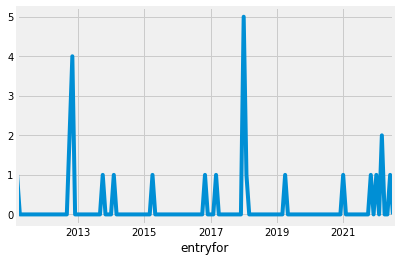

In [17]:
#days count over 95%
over95_count = usage_daytime.resample('D', on='entryfor').over95pct.sum()>=1
over95_count.reset_index().resample('M',on='entryfor').over95pct.sum().plot()

In [18]:
months =[6,7]

source = usage_df.resample('D',on='entryfor')[['year','usage_pct']].max().reset_index()
source = source[source.year>=2011]
source = source[source.entryfor.dt.month.isin(months)]

source['date_type'] = ''

for month in months:
    month_name = pd.to_datetime(month,format='%m').strftime('%B')
    highest = source[source.entryfor.dt.month==month].groupby('year').usage_pct.max().to_dict()
    source.loc[(source.entryfor.dt.month==month)&(source.usage_pct==source.year.map(highest)),'date_type'] = f'highest_point_in_{month_name}'


domain = source.date_type.unique()
range_ = ['skyblue','red','orange']
    
chart = alt.Chart(source).mark_point().encode(
    x='year:N',
    y=alt.Y(
        'usage_pct:Q',
         scale=alt.Scale(domain=(60, 100))
    ),
    #color='date_type:N'
    color =alt.Color('date_type:N', scale=alt.Scale(domain=domain, range=range_))
).configure_axis(
    grid=False
).properties(
    title='maximum usage_pct during each day in June-July'
)

chart.configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='gray'
)

alt.Chart(...)

In [19]:
source = usage_df.resample('D', on='entryfor').usage_pct.max().rename_axis('date').reset_index()
source['month'] = source['date'].dt.strftime('%Y/%m')
source = source[source.date.dt.month.isin([6])]

alt.Chart(source).mark_boxplot(extent='min-max').encode(
    x='month:N',
    y=alt.Y('usage_pct:Q', scale=alt.Scale(domain=(70,100)))
).properties(
    title='usage_pct in June'
)

alt.Chart(...)

In [312]:
#10:00-18:00
#data
source = usage_daytime.resample('D',on='entryfor').usage_pct.max()
source = source.rolling(7).mean().to_frame()
source['date'] = source.index.map(lambda x: x.replace(year=2020))
source['year'] = source.index.year.astype(str)
source = source.dropna(how='any')
source['last_30_days'] = source.index.map(lambda x: (date.today() - x.date()).days <31)

In [302]:
#10:00-18:00
#chart
domain = source.year.unique()
range_ = ['light gray']*(len(domain) -2) + ['pink','red']

alt.Chart(source).mark_line().encode(
    x='date',
    y=alt.Y('usage_pct',scale=alt.Scale(domain=(67, 96))),
    color=alt.Color('year',scale=alt.Scale(domain=domain, range=range_))
).configure_axis(
    grid=False
).properties(
    title='electricity usage / capacity (%) 10:00-18:00'
)

alt.Chart(...)

In [316]:
domain = source.year.unique()
range_ = ['gray']*(len(domain) -1) + ['red']

alt.Chart(source).mark_circle(opacity=0.4, size=6
                             ).encode(
    x='date',
    y=alt.Y('usage_pct',scale=alt.Scale(domain=(67, 96))),
    color=alt.Color('year',scale=alt.Scale(domain=domain, range=range_)),
).configure_axis(
    grid=False
).properties(
    title='electricity usage / capacity (%) 10:00-18:00'
)

alt.Chart(...)

In [319]:
source = source[source.year!='2011']

domain = source.last_30_days.unique()
range_ = ['gray', 'red']

alt.Chart(source).mark_circle(opacity=0.4, size=6
                             ).encode(
    x='date',
    y=alt.Y('usage_pct',scale=alt.Scale(domain=(67, 96))),
    color=alt.Color('last_30_days',scale=alt.Scale(domain=domain, range=range_)),
).configure_axis(
    grid=False
).properties(
    title='electricity usage / capacity (%) 10:00-18:00'
)

alt.Chart(...)

In [354]:
#10:00-18:00
#data
source = usage_bu.resample('D',on='entryfor').usage_pct.max()
source = source.reindex(pd.date_range(date(2011,3,20),date.today(),freq='D')
              ).bfill().rolling(7).mean().reindex(pd.date_range(date(2011,3,27),date.today(),freq='W')
                                                 ).to_frame()
source['date'] = source.index.map(lambda x: x.replace(year=2022))
source['year'] = source.index.year.astype(str)

#chart
domain = source.year.unique()
range_ =['#E8E9EB']*(len(domain) -2) + ['#ffbfbf','#b30000']

chart = alt.Chart(source).mark_line().encode(
    x='date:T',
    y=alt.Y('usage_pct',scale=alt.Scale(domain=(67, 96))),
    color=alt.Color('year',scale=alt.Scale(domain=domain, range=range_))
).configure_axis(
    grid=False
).properties(
    title='electricity usage (pct of capacity) : 10:00-18:00, business days'
)
chart

alt.Chart(...)

In [355]:
chart.save('chart.png')
chart.save('chart.svg')

In [110]:
source = usage_df[['entryfor','usage','capacity','forecast_peak_usage']].sort_values(by='entryfor').dropna(how='any')
source = source.resample('M',on='entryfor').max().reset_index(drop=True)
source = source[source.entryfor.dt.month==6]
source.entryfor = source.entryfor.dt.strftime('%Y/%m/%d')



alt.Chart(source).transform_fold(
    ['usage','capacity','forecast_peak_usage'],as_=['usage','volume']).mark_line().encode(
    x='entryfor:T',
    y=alt.Y('volume:Q',scale=alt.Scale(domain=(3000, 6500))),
    color='usage:N'
).properties(
    title='usage in June'
)

alt.Chart(...)

In [111]:
source = usage_df[['entryfor','usage','capacity']].sort_values(by='entryfor').dropna(how='any')

In [112]:
source = usage_df[['entryfor','usage','capacity']].sort_values(by='entryfor').dropna(how='any')
source = source.resample('D',on='entryfor')[['usage','capacity']].max()\
            .dropna(how='all').reset_index(drop=False)
            #.rolling(7).mean().dropna(how='all').reset_index(drop=False)
source = source[source.entryfor.dt.year==2022]
source.entryfor = source.entryfor.dt.strftime('%Y/%m/%d')



alt.Chart(source).transform_fold(
    ['usage','capacity'],as_=['usage','volume']).mark_line().encode(
    x='entryfor:T',
    y=alt.Y('volume:Q',scale=alt.Scale(domain=(2500, 6500))),
    color='usage:N'
).properties(
    title='usage in June'
)

alt.Chart(...)

In [113]:
source = usage_df[['entryfor','usage','capacity']].sort_values(by='entryfor').dropna(how='any')
source = source.resample('D',on='entryfor')[['usage','capacity']].max().rolling(5).mean().dropna(how='all').reset_index(drop=False)
source = source[source.entryfor.dt.year==2022]
source.entryfor = source.entryfor.dt.strftime('%Y/%m/%d')



alt.Chart(source).transform_fold(
    ['usage','capacity'],as_=['usage','volume']).mark_line().encode(
    x='entryfor:T',
    y=alt.Y('volume:Q',scale=alt.Scale(domain=(2800, 6000))),
    color='usage:N'
).properties(
    title='usage in June'
)

alt.Chart(...)

In [114]:
#data
source = usage_df.resample('M',on='entryfor').max()[['year','month','usage_pct']].reset_index(drop=True)
source = source.pivot(index='month',columns='year', values='usage_pct')
source.index = pd.to_datetime(source.index,format='%m').strftime('%B')
source.columns =source.columns.astype(str)
source = source.loc[:,'2013':]

Text(0.5, 1.0, 'minimum gap between capacity and usage 10:00AM - 6:00PM')

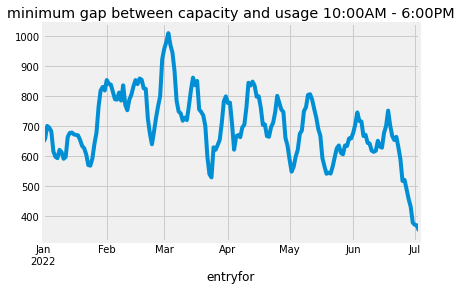

In [115]:
hours=np.arange(10,19)
year = 2021

source = usage_df[usage_df.hour.isin(hours)].resample('D', on='entryfor').capacity_left.min()
source = source.rolling(7).mean()

source[source.index.year>year].plot()
plt.title('minimum gap between capacity and usage 10:00AM - 6:00PM')

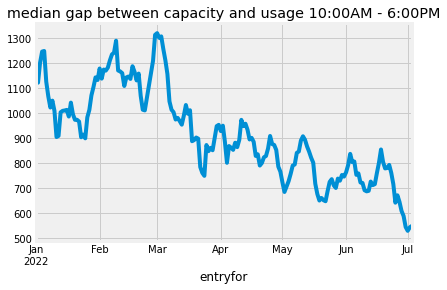

In [116]:
source = usage_df[usage_df.hour.isin(hours)].resample('D', on='entryfor').capacity_left.median()
source = source.rolling(7).mean()

source[source.index.year>year].plot()
plt.title('median gap between capacity and usage 10:00AM - 6:00PM')
plt.show()